## Imports

In [1]:
import os
import cv2 as cv
import json
import matplotlib
import matplotlib.pyplot as plt
import glob
import pandas as pd
import random
from tqdm import tqdm

from torchvision.transforms import v2
import torch
from torch.utils.data import DataLoader

#Ignore user warnings
import warnings
warnings.filterwarnings("ignore")

## Checking Annotations

In [2]:
# Read a JSON file
with open('data/Annotations/train.json') as f:
    trainJSON = json.load(f)

with open('data/Annotations/val.json') as f:
    valJSON = json.load(f)

with open('data/Annotations/test.json') as f:
    testJSON = json.load(f)

In [3]:
classes = trainJSON['categories']

train_images = trainJSON['images']
val_images = valJSON['images']
test_images = testJSON['images']

train_annotations = trainJSON['annotations']
val_annotations = valJSON['annotations']
test_annotations = testJSON['annotations']

In [4]:
print('========= Classes =========')
display(classes)
print('========= Train images =========')
display(train_images[:2])
print('========= Train nnotations =========')
display(train_annotations[:2])

========= Classes =========


[{'id': 1, 'name': 'LE;ER', 'supercategory': None},
 {'id': 4, 'name': 'SF;PO', 'supercategory': None},
 {'id': 0, 'name': 'VG;MT', 'supercategory': None},
 {'id': 2, 'name': 'LR;DA', 'supercategory': None},
 {'id': 3, 'name': 'LE;CR', 'supercategory': None}]

========= Train images =========


[{'id': 0,
  'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/',
  'file_name': 'DJI_0058_1_3.JPG',
  'path': None,
  'width': 1024,
  'height': 1024,
  'depth': 3},
 {'id': 1,
  'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/',
  'file_name': 'DJI_0013_0_3.JPG',
  'path': None,
  'width': 1024,
  'height': 1024,
  'depth': 3}]

========= Train nnotations =========


[{'image_id': 0,
  'id': 0,
  'segmented': None,
  'bbox': [383.996928, 424.001024, 99.00032, 90.000384],
  'area': 8910.0668161229,
  'segmentation': None,
  'iscrowd': 0,
  'pose': None,
  'truncated': None,
  'category_id': 1,
  'difficult': None},
 {'image_id': 0,
  'id': 1,
  'segmented': None,
  'bbox': [616.001024, 20.00128, 45.999104, 47.000576],
  'area': 2161.9843834839,
  'segmentation': None,
  'iscrowd': 0,
  'pose': None,
  'truncated': None,
  'category_id': 4,
  'difficult': None}]

In [5]:
train_images_names = []
val_images_names = []
test_images_names = []

for metadata in train_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    train_images_names.append(img_name)

for metadata in val_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    val_images_names.append(img_name)

for metadata in test_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    test_images_names.append(img_name)

# Drop duplicates from the lists
train_images_names = list(set(train_images_names))
val_images_names = list(set(val_images_names))
test_images_names = list(set(test_images_names))

In [6]:
print('========= Train images names =========')
display(train_images_names[:11])
print('========= Validation images names =========')
display(val_images_names[:11])
print('========= Test images names =========')
display(test_images_names[:11])

========= Train images names =========


['DJI_0328.JPG',
 'DJI_0412.JPG',
 'DJI_0165.JPG',
 'DJI_0156.JPG',
 'DJI_0442.JPG',
 'DJI_0444.JPG',
 'DJI_0409.JPG',
 'DJI_0625.JPG',
 'DJI_0097.JPG',
 'DJI_0700.JPG',
 'DJI_0382.JPG']

========= Validation images names =========


['DJI_0130.JPG',
 'DJI_0006.JPG',
 'DJI_0426.JPG',
 'DJI_0121.JPG',
 'DJI_0106.JPG',
 'DJI_0185.JPG',
 'DJI_0096.JPG',
 'DJI_0331.JPG',
 'DJI_0236.JPG',
 'DJI_0119.JPG',
 'DJI_0171.JPG']

========= Test images names =========


['DJI_0021.JPG',
 'DJI_0413.JPG',
 'DJI_0376.JPG',
 'DJI_0710.JPG',
 'DJI_0687.JPG',
 'DJI_0054.JPG',
 'DJI_0112.JPG',
 'DJI_0184.JPG',
 'DJI_0036.JPG',
 'DJI_0029.JPG',
 'DJI_0157.JPG']

## Data Preparation

In [7]:
class NordtankDataset(torch.utils.data.Dataset):
    def __init__(self, images_names, transform = None):
        self.images_names = images_names
        self.transform = transform

    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, idx):
        img_name = self.images_names[idx]
        img_path = img_name
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = torch.from_numpy(image.transpose(2, 0, 1))

        if self.transform:
            image = self.transform(image)
    
        image = image.permute(1, 2, 0)

        return image


# Divide test_image into several images with 1024x1024 pixels excluding the sub-images that are not 1024x1024 pixels
def DivideImage(image, size):
    sub_images = []
    h, w, c = image.shape
    for i in range(0, h, size):
        for j in range(0, w, size):
            sub_images.append(image[i:i+size, j:j+size])

    # Remove the sub-images that are not 1024x1024 pixels
    sub_images = [sub_image for sub_image in sub_images if sub_image.shape == (size, size, c)]

    return sub_images


# Plot test image with red squares showing the sub-images
def PlotDividedImage(image, size):
    # image: a PyTorch tensor with shape (H, W, C)
    # size: the size of the sub-images (size x size)
    H, W, C = image.shape
    sub_images = DivideImage(image, size)
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(0, H, size):
        for j in range(0, W, size):
            rect = matplotlib.patches.Rectangle((j, i), size, size, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.show()


# Plot the bounding box of the annotation in an image
def PlotBoundingBox(image, bbox):
    # image: a PyTorch tensor with shape (H, W, C)
    # annotation: a dictionary with the annotation of the image
    fig, ax = plt.subplots()
    ax.imshow(image)
    x, y, w, h = bbox
    rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()


def CreateDatasetSubImages(dataset, dataframe, train_image_path_lst, size):
    sub_images = []
    sub_labels = []
    bboxes = []

    for image_name in dataframe['file_name'].unique():
        sub_images_df = dataframe[dataframe['file_name'] == image_name]
        sub_image_labels = [-1] * 10
        bboxes_sub_image = [None] * 10

        idx = train_image_path_lst.index('data/Images/' + image_name)
        image = dataset[idx]
        for index, sub_image in sub_images_df.iterrows():
            row = int(sub_image['sub_image_row'])
            col = int(sub_image['sub_image_col'])
            sub_image_labels[(row * 5) + col] = int(sub_image['category_id'])
            bboxes_sub_image[(row * 5) + col] = sub_image['bbox']

        sub_images += DivideImage(image, size)
        sub_labels += sub_image_labels
        bboxes += bboxes_sub_image
        
    return sub_images, sub_labels, bboxes


# Define a function that duplicates the images from a list with random sampling until a certain number of images is reached
def DuplicateImages(image_lst, target_size):
    initial_size = len(image_lst)
    current_size = len(image_lst)
    image_lst_copy = image_lst.copy()

    while current_size < target_size - initial_size:
        random_element = random.choice(image_lst)
        image_lst_copy.append(random_element)
        current_size += 1

    return image_lst_copy


def GetSubImagesByLabel(sub_images, sub_labels):

    idx_neg1 = []
    idx_zero = []
    idx_one = []
    idx_two = []
    idx_three = []
    idx_four = []

    for idx, label in enumerate(sub_labels):
        if label == -1:
            idx_neg1.append(idx)
        elif label == 0:
            idx_zero.append(idx)
        elif label == 1:
            idx_one.append(idx)
        elif label == 2:
            idx_two.append(idx)
        elif label == 3:
            idx_three.append(idx)
        else:
            idx_four.append(idx)


    sub_images_neg1 = [sub_images[idx] for idx in idx_neg1]
    sub_images_zero = [sub_images[idx] for idx in idx_zero]
    sub_images_one = [sub_images[idx] for idx in idx_one]
    sub_images_two = [sub_images[idx] for idx in idx_two]
    sub_images_three = [sub_images[idx] for idx in idx_three]
    sub_images_four = [sub_images[idx] for idx in idx_four]

    return sub_images_neg1, sub_images_zero, sub_images_one, sub_images_two, sub_images_three, sub_images_four


def IntegrateImagesAnnotations(images, annotations):

    images_df = pd.DataFrame(images)
    annotations_df = pd.DataFrame(annotations)

    images_df.drop(columns = ['folder', 'path', 'width', 'height', 'depth'], inplace = True)
    annotations_df.drop(columns = ['segmented', 'area', 'segmentation', 'iscrowd', 'pose', 'truncated', 'difficult'], inplace = True)

    # Create two new columns in train_images_df that contain the row and column of the sub-image with the annotation
    images_df['sub_image_row'] = images_df['file_name'].str[9:10].astype(int)
    images_df['sub_image_col'] = images_df['file_name'].str[11:12].astype(int)
    images_df['file_name'] = images_df['file_name'].str[:8] + images_df['file_name'].str[-4:]

    #Change the name of the column "id" to "image_id" in the train_images_df
    images_df.rename(columns = {'id': 'image_id'}, inplace = True)

    # Merge train_images_df and train_annotations_df using the key "image_id"
    df = pd.merge(images_df, annotations_df, on = 'image_id').drop(columns = ['id'])

    # Delete all rows that have duplicate values in the columns "image_id", "sub_image_row", and "sub_image_col"
    df.drop_duplicates(subset = ['image_id', 'sub_image_row', 'sub_image_col'], keep = False, inplace = True)

    return df

In [8]:
train_df = IntegrateImagesAnnotations(train_images, train_annotations)
val_df = IntegrateImagesAnnotations(val_images, val_annotations)
test_df = IntegrateImagesAnnotations(test_images, test_annotations)

In [9]:
# Obter todos os caminhos das imagens no diretório 'data/Images'
images = glob.glob('data/Images/*.JPG')

# Inicializar listas de caminhos para treino, validação e teste
train_images_paths = []
val_images_paths = []
test_images_paths = []

# Iterar sobre todas as imagens e adicionar aos respectivos conjuntos
for img in images:
    img_name = os.path.basename(img)  # Obter o nome do arquivo da imagem

    if img_name in train_images_names:
        train_images_paths.append(img.replace("\\", "/"))

    elif img_name in val_images_names:
        val_images_paths.append(img.replace("\\", "/"))

    elif img_name in test_images_names:
        test_images_paths.append(img.replace("\\", "/"))

# Imprimir os caminhos corrigidos
print(train_images_paths)
print(val_images_paths)
print(test_images_paths)

['data/Images/DJI_0004.JPG', 'data/Images/DJI_0005.JPG', 'data/Images/DJI_0007.JPG', 'data/Images/DJI_0008.JPG', 'data/Images/DJI_0009.JPG', 'data/Images/DJI_0010.JPG', 'data/Images/DJI_0011.JPG', 'data/Images/DJI_0012.JPG', 'data/Images/DJI_0013.JPG', 'data/Images/DJI_0014.JPG', 'data/Images/DJI_0016.JPG', 'data/Images/DJI_0017.JPG', 'data/Images/DJI_0018.JPG', 'data/Images/DJI_0019.JPG', 'data/Images/DJI_0020.JPG', 'data/Images/DJI_0022.JPG', 'data/Images/DJI_0023.JPG', 'data/Images/DJI_0024.JPG', 'data/Images/DJI_0025.JPG', 'data/Images/DJI_0027.JPG', 'data/Images/DJI_0028.JPG', 'data/Images/DJI_0030.JPG', 'data/Images/DJI_0031.JPG', 'data/Images/DJI_0032.JPG', 'data/Images/DJI_0034.JPG', 'data/Images/DJI_0035.JPG', 'data/Images/DJI_0037.JPG', 'data/Images/DJI_0044.JPG', 'data/Images/DJI_0046.JPG', 'data/Images/DJI_0049.JPG', 'data/Images/DJI_0050.JPG', 'data/Images/DJI_0051.JPG', 'data/Images/DJI_0052.JPG', 'data/Images/DJI_0056.JPG', 'data/Images/DJI_0057.JPG', 'data/Images/DJI_00

In [10]:
TrainOriginalDataset = NordtankDataset(train_images_paths)
ValOriginalDataset = NordtankDataset(val_images_paths)
TestOriginalDataset = NordtankDataset(test_images_paths)

train_sub_images, train_sub_labels, bboxes = CreateDatasetSubImages(TrainOriginalDataset, train_df, train_images_paths, 1024)
val_sub_images, val_sub_labels, bboxes = CreateDatasetSubImages(ValOriginalDataset, val_df, val_images_paths, 1024)
test_sub_images, test_sub_labels, bboxes = CreateDatasetSubImages(TestOriginalDataset, test_df, test_images_paths, 1024)

In [11]:
train_sub_images_neg1, train_sub_images_zero, train_sub_images_one, \
train_sub_images_two, train_sub_images_three, train_sub_images_four = GetSubImagesByLabel(train_sub_images, train_sub_labels)

val_sub_images_neg1, val_sub_images_zero, val_sub_images_one, \
val_sub_images_two, val_sub_images_three, val_sub_images_four = GetSubImagesByLabel(val_sub_images, val_sub_labels)

test_sub_images_neg1, test_sub_images_zero, test_sub_images_one, \
test_sub_images_two, test_sub_images_three, test_sub_images_four = GetSubImagesByLabel(test_sub_images, test_sub_labels)


sub_images_zero_dup = DuplicateImages(train_sub_images_zero, 1529)
sub_images_one_dup = DuplicateImages(train_sub_images_one, 1529)
sub_images_two_dup = DuplicateImages(train_sub_images_two, 1529)
sub_images_three_dup = DuplicateImages(train_sub_images_three, 1529)
sub_images_four_dup = DuplicateImages(train_sub_images_four, 1529)

sub_images_per_category_dup = [sub_images_zero_dup, sub_images_one_dup, sub_images_two_dup, sub_images_three_dup, sub_images_four_dup]
train_sub_images_per_category = [train_sub_images_zero, train_sub_images_one, train_sub_images_two, train_sub_images_three, train_sub_images_four, train_sub_images_neg1]
val_sub_images_per_category = [val_sub_images_zero, val_sub_images_one, val_sub_images_two, val_sub_images_three, val_sub_images_four, val_sub_images_neg1]
test_sub_images_per_category = [test_sub_images_zero, test_sub_images_one, test_sub_images_two, test_sub_images_three, test_sub_images_four, test_sub_images_neg1]

## Data Augmentation

In [28]:
class NordtankSubImagesDataset(torch.utils.data.Dataset):
    def __init__(self, images, label, transform=None):
        self.images = images
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        sub_image = self.images[idx]

        # Apply the same label to the entire dataset
        sub_label = self.label

        sub_image = sub_image.permute(2, 0, 1)

        if self.transform:
            sub_image = self.transform(sub_image)

        sub_image = sub_image.permute(1, 2, 0)

        return sub_image, sub_label
    


def BeforeAfterDataAugmentation(aug_dataset, originals_dataset, idx):

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(originals_dataset[idx][0])
    axes[0].set_title('Before data augmentation')
    axes[1].imshow(aug_dataset[idx][0])
    axes[1].set_title('After data augmentation')


def CreateFinalDataset(sub_images_per_class, sub_images_per_class_dup = [], transform = None):

    if len(sub_images_per_class_dup) != 0:

        # Create a NordtankDataset dataset for each label's images
        DatasetAugmented_zero = NordtankSubImagesDataset(images = sub_images_per_class_dup[0], label = 0, transform = transform)
        DatasetAugmented_one = NordtankSubImagesDataset(images = sub_images_per_class_dup[1], label = 1, transform = transform)
        DatasetAugmented_two = NordtankSubImagesDataset(images = sub_images_per_class_dup[2], label = 2, transform = transform)
        DatasetAugmented_three = NordtankSubImagesDataset(images = sub_images_per_class_dup[3], label = 3, transform = transform)
        DatasetAugmented_four = NordtankSubImagesDataset(images = sub_images_per_class_dup[4], label = 4, transform = transform)

        DatasetOriginal_zero = NordtankSubImagesDataset(images = sub_images_per_class[0], label = 0)
        DatasetOriginal_one = NordtankSubImagesDataset(images = sub_images_per_class[1], label = 1)
        DatasetOriginal_two = NordtankSubImagesDataset(images = sub_images_per_class[2], label = 2)
        DatasetOriginal_three = NordtankSubImagesDataset(images = sub_images_per_class[3], label = 3)
        DatasetOriginal_four = NordtankSubImagesDataset(images = sub_images_per_class[4], label = 4)

        Dataset_neg1 = NordtankSubImagesDataset(images = sub_images_per_class[5], label = 5)
        Dataset_zero = torch.utils.data.ConcatDataset([DatasetOriginal_zero, DatasetAugmented_zero])
        Dataset_one = torch.utils.data.ConcatDataset([DatasetOriginal_one, DatasetAugmented_one])
        Dataset_two = torch.utils.data.ConcatDataset([DatasetOriginal_two, DatasetAugmented_two])
        Dataset_three = torch.utils.data.ConcatDataset([DatasetOriginal_three, DatasetAugmented_three])
        Dataset_four = torch.utils.data.ConcatDataset([DatasetOriginal_four, DatasetAugmented_four])

        Dataset = torch.utils.data.ConcatDataset([Dataset_neg1, Dataset_zero, Dataset_one, Dataset_two, Dataset_three, Dataset_four])

        return Dataset, DatasetAugmented_one, DatasetOriginal_one

    else:
        Dataset_zero = NordtankSubImagesDataset(images = sub_images_per_class[0], label = 0)
        Dataset_one = NordtankSubImagesDataset(images = sub_images_per_class[1], label = 1)
        Dataset_two = NordtankSubImagesDataset(images = sub_images_per_class[2], label = 2)
        Dataset_three = NordtankSubImagesDataset(images = sub_images_per_class[3], label = 3)
        Dataset_four = NordtankSubImagesDataset(images = sub_images_per_class[4], label = 4)

        Dataset_neg1 = NordtankSubImagesDataset(images = sub_images_per_class[5], label = 5)

        Dataset = torch.utils.data.ConcatDataset([Dataset_neg1, Dataset_zero, Dataset_one, Dataset_two, Dataset_three, Dataset_four])

    return Dataset

In [29]:
transform = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    v2.ToTensor(),
    #v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [31]:
TrainDataset, TrainDatasetAugmented_one, TrainDatasetOriginal_one = CreateFinalDataset(train_sub_images_per_category, sub_images_per_category_dup, transform)
ValDataset = CreateFinalDataset(val_sub_images_per_category)
TestDataset = CreateFinalDataset(test_sub_images_per_category)

In [32]:
print('Length of TrainDataset (should be equal to 1529 * 6):       {}'.format(len(TrainDataset)))
print('Number of images with label 1 on TrainDataset:              {}'.format(len(TrainDatasetAugmented_one) + len(TrainDatasetOriginal_one)))
print()
print()
print('Number of images with label 0 on ValDataset:                {}'.format(len([label for _, label in ValDataset if label == 0])))
print('Number of images with label 1 on ValDataset:                {}'.format(len([label for _, label in ValDataset if label == 1])))
print('Number of images with label 2 on ValDataset:                {}'.format(len([label for _, label in ValDataset if label == 2])))
print('Number of images with label 3 on ValDataset:                {}'.format(len([label for _, label in ValDataset if label == 3])))
print('Number of images with label 4 on ValDataset:                {}'.format(len([label for _, label in ValDataset if label == 4])))
print('Number of images with label 5 on ValDataset (no category):  {}'.format(len([label for _, label in ValDataset if label == 5])))
print()
print()
print('Number of images with label 0 on TestDataset:                {}'.format(len([label for _, label in TestDataset if label == 0])))
print('Number of images with label 1 on TestDataset:                {}'.format(len([label for _, label in TestDataset if label == 1])))
print('Number of images with label 2 on TestDataset:                {}'.format(len([label for _, label in TestDataset if label == 2])))
print('Number of images with label 3 on TestDataset:                {}'.format(len([label for _, label in TestDataset if label == 3])))
print('Number of images with label 4 on TestDataset:                {}'.format(len([label for _, label in TestDataset if label == 4])))
print('Number of images with label 5 on TestDataset (no category):  {}'.format(len([label for _, label in TestDataset if label == 5])))

Length of TrainDataset (should be equal to 1529 * 6):       9174
Number of images with label 1 on TrainDataset:              1529


Number of images with label 0 on ValDataset:                15
Number of images with label 1 on ValDataset:                23
Number of images with label 2 on ValDataset:                2
Number of images with label 3 on ValDataset:                10
Number of images with label 4 on ValDataset:                8
Number of images with label 5 on ValDataset (no category):  312


Number of images with label 0 on TestDataset:                17
Number of images with label 1 on TestDataset:                31
Number of images with label 2 on TestDataset:                5
Number of images with label 3 on TestDataset:                7
Number of images with label 4 on TestDataset:                6
Number of images with label 5 on TestDataset (no category):  334


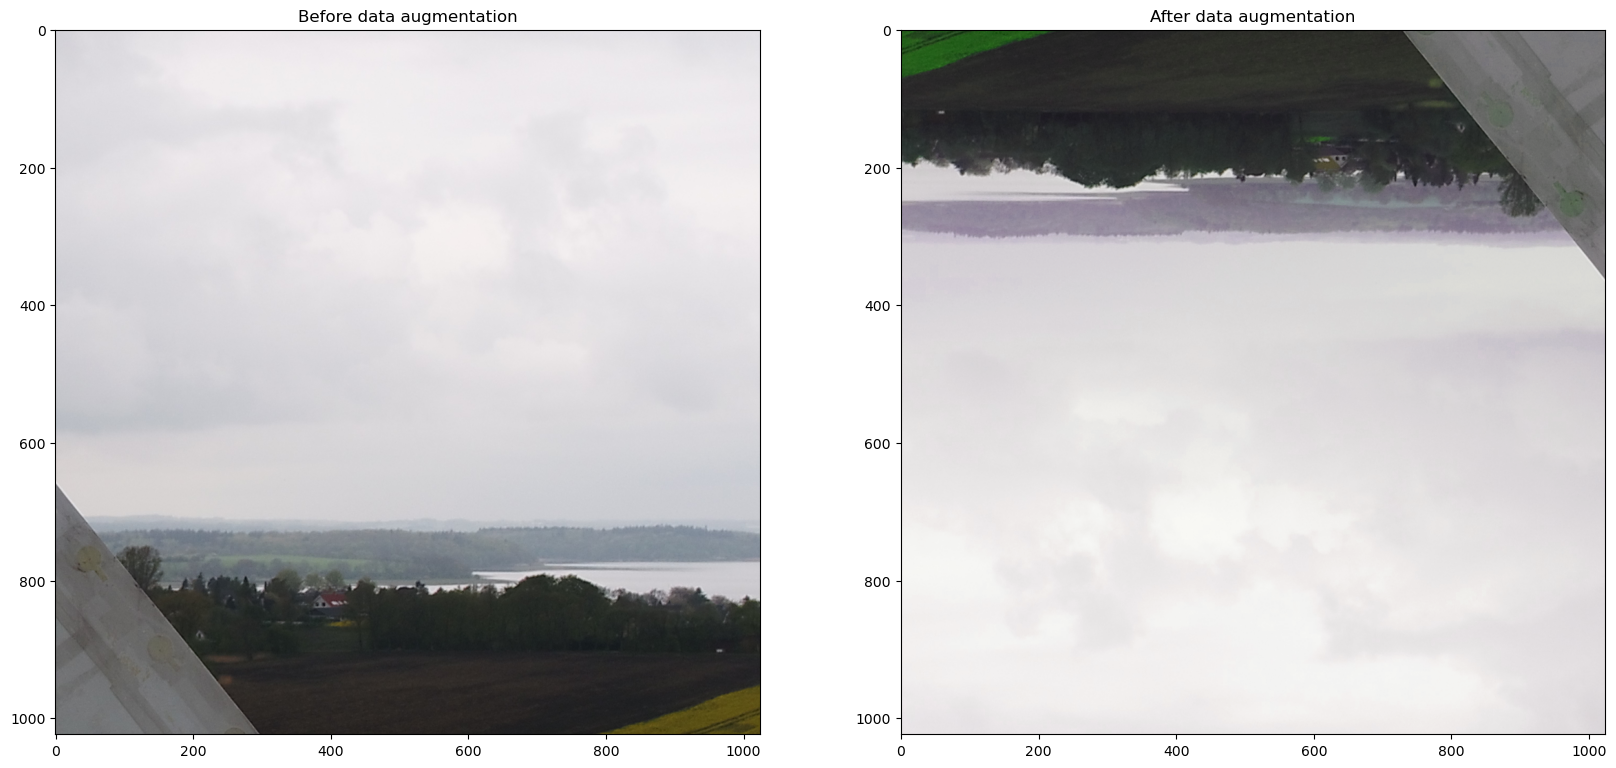

In [33]:
BeforeAfterDataAugmentation(TrainDatasetAugmented_one, TrainDatasetOriginal_one, 1)

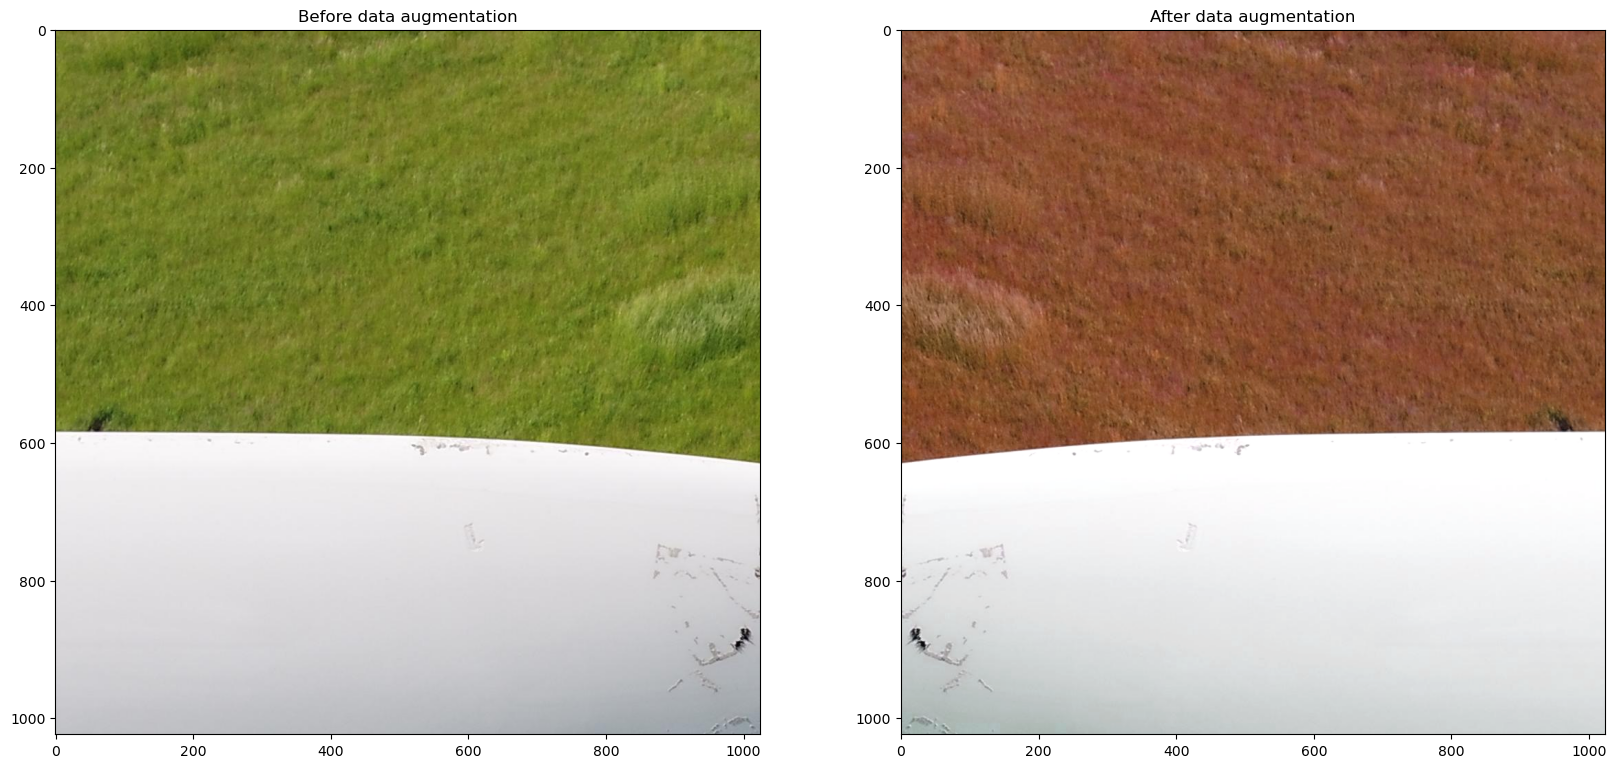

In [17]:
BeforeAfterDataAugmentation(TrainDatasetAugmented_one, TrainDatasetOriginal_one, 3)

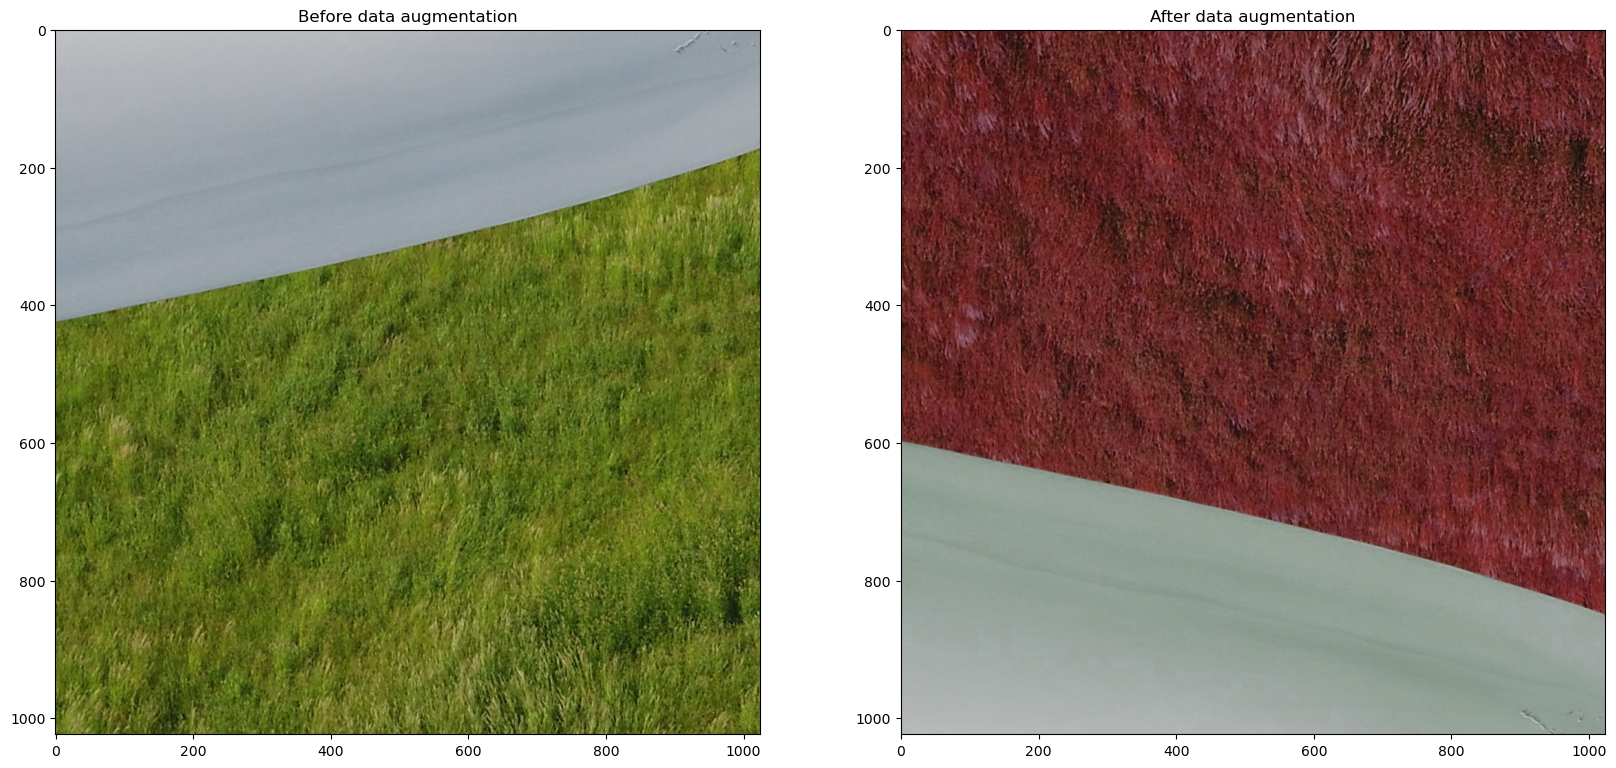

In [18]:
BeforeAfterDataAugmentation(TrainDatasetAugmented_one, TrainDatasetOriginal_one, 5)

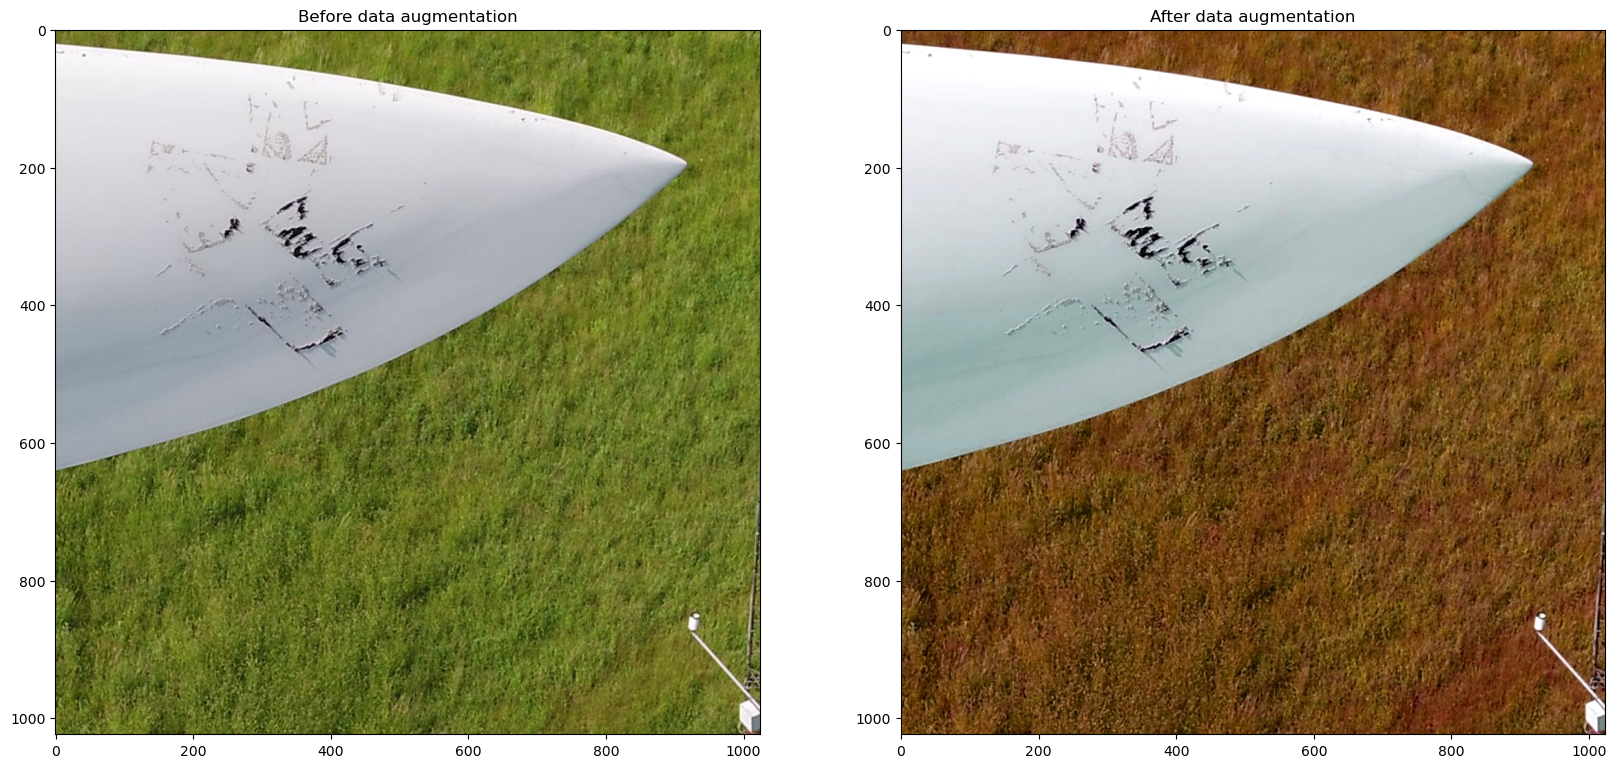

In [19]:
BeforeAfterDataAugmentation(TrainDatasetAugmented_one, TrainDatasetOriginal_one, 7)

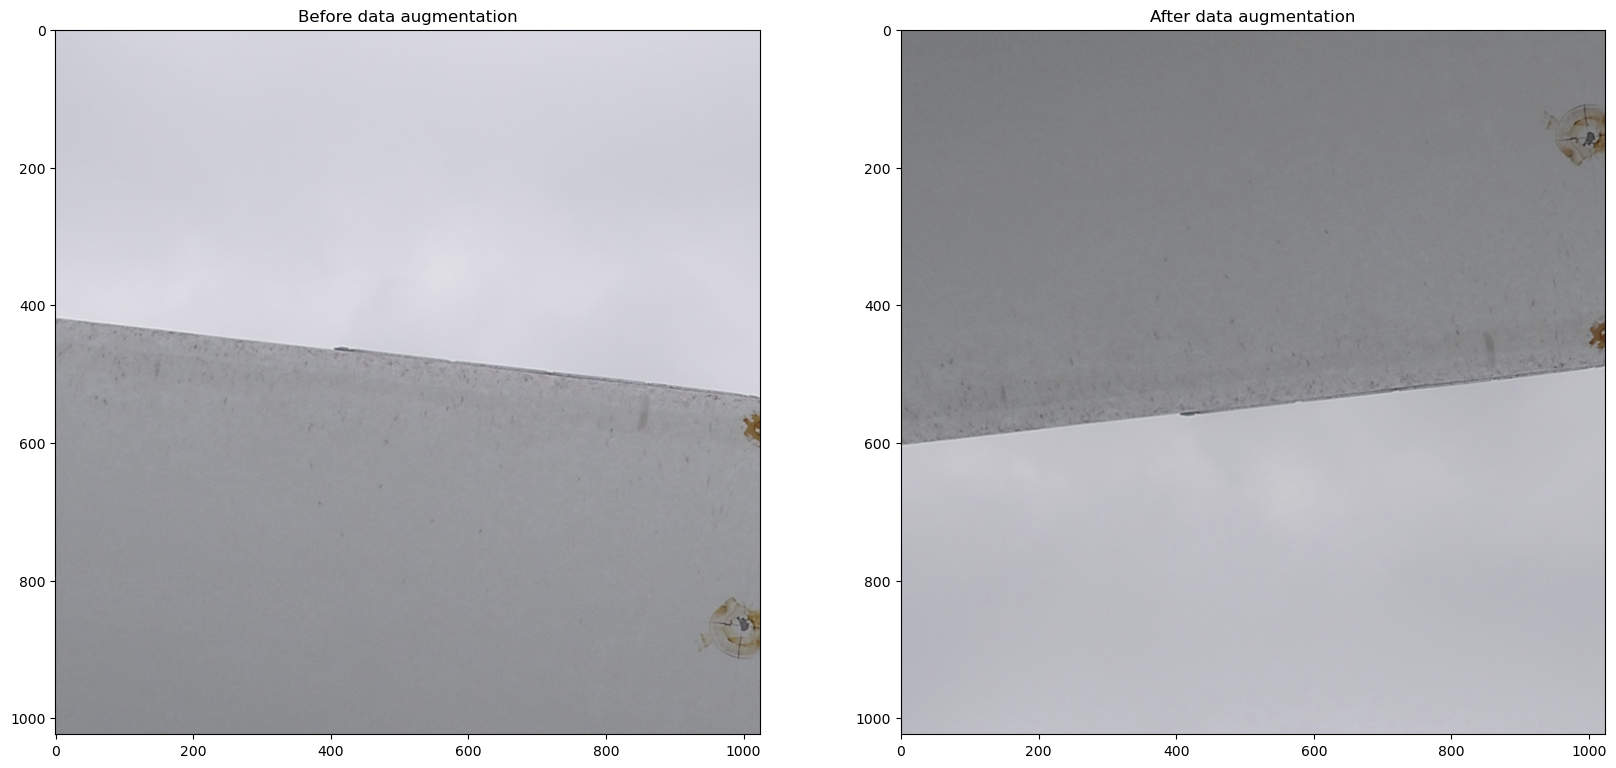

In [20]:
BeforeAfterDataAugmentation(TrainDatasetAugmented_one, TrainDatasetOriginal_one, 11)

## Convolutional Neural Network

In [34]:
# Use DataLoader to handle batching and shuffling
batch_size = 256

TrainDatasetLoader = DataLoader(TrainDataset, batch_size=batch_size, shuffle=True)
ValDatasetLoader = DataLoader(ValDataset, batch_size=batch_size, shuffle=False)
TestDatasetLoader = DataLoader(TestDataset, batch_size=batch_size, shuffle=False)

In [37]:
# Create a class that creates a simple CNN
class ConvolutionalNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv_3_16 = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=8, stride=2, padding=1)
        self.conv_16_32 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=8, stride=2, padding=1)
        self.conv_32_64 = torch.nn.Conv2d(in_channels=16, out_channels=20, kernel_size=8, stride=2, padding=1)
        self.conv_64_128 = torch.nn.Conv2d(in_channels=20, out_channels=20, kernel_size=8, stride=2, padding=1)
        self.conv_128_256 = torch.nn.Conv2d(in_channels=20, out_channels=20, kernel_size=8, stride=2, padding=1)
        # Max pooling layers
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size = 2, stride = 1)
        self.max_pool_10 = torch.nn.MaxPool2d(kernel_size = 10, stride = 1)
        self.max_pool_15 = torch.nn.MaxPool2d(kernel_size = 15, stride = 1)
        self.max_pool_20 = torch.nn.MaxPool2d(kernel_size = 20, stride = 1)
        # Flatten layer
        self.flatten = torch.nn.Flatten()
        # Fully connected layers
        self.fc_40000_16384 = torch.nn.Linear(40000, 16384)
        self.fc_12500_4096 = torch.nn.Linear(12500, 4096)
        self.fc_4096_512 = torch.nn.Linear(4096, 512)
        self.fc_512_128 = torch.nn.Linear(512, 128)
        self.fc_16384_8192 = torch.nn.Linear(16384, 8192)
        self.fc_8192_4096 = torch.nn.Linear(8192, 4096)
        self.fc_4096_2048 = torch.nn.Linear(4096, 2048)
        self.fc_2048_1024 = torch.nn.Linear(2048, 1024)
        self.fc_1024_512 = torch.nn.Linear(1024, 512)
        self.fc_512_256 = torch.nn.Linear(512, 256)
        self.fc_256_128 = torch.nn.Linear(256, 128)
        self.fc_128_64 = torch.nn.Linear(128, 64)
        self.fc_64_32 = torch.nn.Linear(64, 32)
        self.output_layer = torch.nn.Linear(64, 6)
        # Activation functions
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.relu6 = torch.nn.ReLU6()
        self.leaky_relu = torch.nn.LeakyReLU()
        self.prelu = torch.nn.PReLU()
        # Dropout layers
        self.dropout_10 = torch.nn.Dropout(0.1)
        self.dropout_20 = torch.nn.Dropout(0.2)
        self.dropout_30 = torch.nn.Dropout(0.3)
        self.dropout_40 = torch.nn.Dropout(0.4)
        self.dropout_50 = torch.nn.Dropout(0.5)
        self.dropout_60 = torch.nn.Dropout(0.6)
        self.dropout_70 = torch.nn.Dropout(0.7)
        # Batch normalization layers
        self.batch_norm32768 = torch.nn.BatchNorm1d(32768)
        self.batch_norm16384 = torch.nn.BatchNorm1d(16384)
        self.batch_norm8192 = torch.nn.BatchNorm1d(8192)
        self.batch_norm4096 = torch.nn.BatchNorm1d(4096)
        self.batch_norm2048 = torch.nn.BatchNorm1d(2048)
        self.batch_norm1024 = torch.nn.BatchNorm1d(1024)
        self.batch_norm512 = torch.nn.BatchNorm1d(512)
        self.batch_norm256 = torch.nn.BatchNorm1d(256)
        self.batch_norm128 = torch.nn.BatchNorm1d(128)
        self.batch_norm64 = torch.nn.BatchNorm1d(64)
        self.batch_norm32 = torch.nn.BatchNorm1d(32)

    def forward(self, x):
        # Convolutional layers
        x = self.max_pool_2(self.relu(self.conv_3_16(x)))
        x = self.max_pool_2(self.relu(self.conv_16_32(x)))
        x = self.max_pool_2(self.relu(self.conv_32_64(x)))
        x = self.max_pool_2(self.relu(self.conv_64_128(x)))
        x = self.max_pool_2(self.relu(self.conv_128_256(x)))
        # Flatten layer
        x = self.flatten(x)
        # Fully connected layers
        # 12500 = 25 * 25 * 20 (25x25 is the size of the image after the last max pooling layer... I think)
        x = self.relu(self.batch_norm4096(self.fc_12500_4096(x)))
        x = self.relu(self.batch_norm1024(self.fc_4096_512(x)))
        x = self.relu(self.batch_norm128(self.fc_512_128(x)))
        x = self.relu(self.batch_norm64(self.fc_128_64(x)))
        x = self.output_layer(x)

        return x

In [40]:

def train(model, train_loader, optimizer, loss_func, epochs, device, **kwargs):

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_hist, train_acc_hist = [], []

    # Add this line to create a plot
    plt.figure(figsize=(10, 5))
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('Training phase...')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(train_loader), total = len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.permute(0, 3, 1, 2).to(device, dtype=torch.float32)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} ')

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print()

        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)

        # Add this line to update the plot
        plt.plot(range(1, epoch + 2), train_loss_hist)

    # Add this line to show the legend and display the plot
    plt.legend()
    plt.show()

    print(f"Cross-Entropy on training set:  {train_loss_hist[-1]:.4f}")
    print(f"Accuracy on training set:       {train_acc_hist[-1]:.2f}%")

    return train_loss_hist, train_acc_hist


def set_device(device_type='cuda'):
    if device_type == 'cuda' and torch.cuda.is_available():
        device = torch.device('cuda')
    elif device_type == 'mps' and torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
    print('Device:', device)
    return device

In [41]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 128 * 128, 512)
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 128 * 128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [42]:
# Initialize the network, loss function, and optimizer
device = set_device()
#model = ConvolutionalNeuralNetwork().to(device)
model = SimpleCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

Device: cpu


Epoch 1/8
Training phase...


  0%|          | 0/36 [02:46<?, ?it/s]


RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 8589934592 bytes.

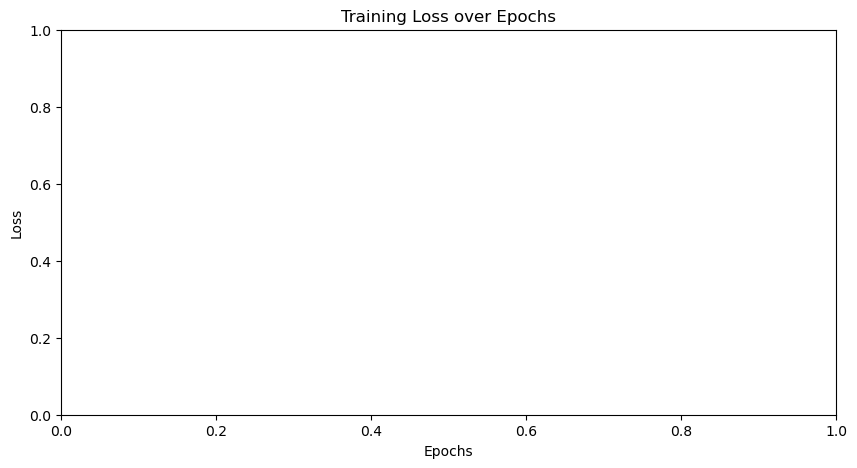

In [43]:
train_loss_hist, train_acc_hist = train(model, TrainDatasetLoader, optimizer, criterion, epochs = 8, device = device)

In [50]:
def evaluate(model, val_loader, loss_func, device):
    model.eval()
    val_loss = 0.
    total = 0.
    correct = 0.

    with torch.no_grad():
        for data, target in tqdm(val_loader):
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = loss_func(output, target)
            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f'Validation Cross-Entropy Loss = {val_loss:.4f}')
    print(f'Validation Accuracy = {val_accuracy:.2f}%')
    print()

    return val_loss, val_accuracy

In [ ]:
# Agora, avalie o modelo no conjunto de validação
val_loss, val_accuracy = evaluate(model, ValDatasetLoader, criterion, device)

# Faça o que desejar com os resultados, como imprimir ou salvar
print(f'Final Validation Cross-Entropy Loss = {val_loss:.4f}')
print(f'Final Validation Accuracy = {val_accuracy:.2f}%')

In [ ]:
#Para considerar se quisermos aplicar o Tensorboard
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter()


for epoch in range(epochs):
    for batch in TrainDatasetLoader:
            #adicionar treino aqui

    val_loss, val_accuracy = evaluate(model, ValDatasetLoader, criterion, device)
    

    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)


writer.close()
